### Import libraries

In [1]:
# for load dataset
from google.colab import drive
import sys
from pathlib import Path
# for data processing
import numpy as np # linear algebra
import pandas as pd
# for train data split
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [2]:
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [3]:
base = Path('/gdrive/MyDrive/ML_Final/')
sys.path.append(str(base))

In [4]:
zip_path = base/'tabular.zip'
!cp "{zip_path}" .
!unzip -q tabular.zip
!rm tabular.zip

In [14]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Data Preprocess

In [6]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [7]:
test_df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [8]:
print('train: ', train_df.shape)
print('test: ', test_df.shape)

train:  (26570, 26)
test:  (20775, 25)


### Feature importance

In [15]:
# Replace category columns with integer values in dataset
train_df['product_code'] = train_df['product_code'].factorize()[0]
train_df['attribute_0'] = train_df['attribute_0'].str.lstrip('material_').astype('int')
train_df['attribute_1'] = train_df['attribute_1'].str.lstrip('material_').astype('int')


In [16]:
train_X = train_df.drop('failure', axis=1)
train_y = train_df['failure']

In [17]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(train_X, train_y)
importances = pd.DataFrame(data={
    'Attribute': train_X.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

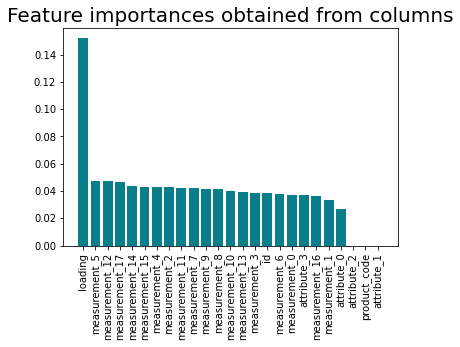

In [19]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from columns', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Data Visualization

In [9]:
# Replace missing columns with incomplete values in dataset

null_cols_number = []
for i in train_df.columns:
  if train_df[i].isna().value_counts()[0]-len(train_df[i]) < 0:
    null_cols_number.append(i)

for col in null_cols_number:
  null_cols = train_df[train_df[col].isna()].index
  for n in null_cols:
    train_df.loc[n,col] = train_df[col].mean()

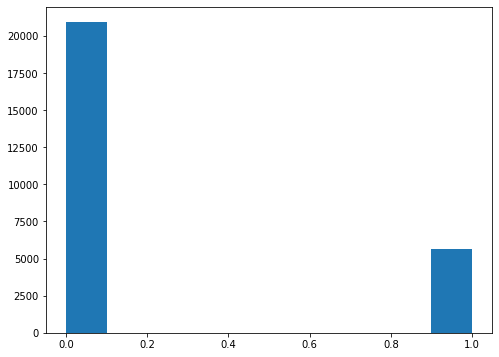

In [14]:
# failure histogram
plt.figure(figsize=(8,6))
plt.hist(train_df['failure']);

<ipython-input-17-a241e45f0bc5>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(8, 6))
<ipython-input-17-a241e45f0bc5>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(8, 6))
<ipython-input-17-a241e45f0bc5>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

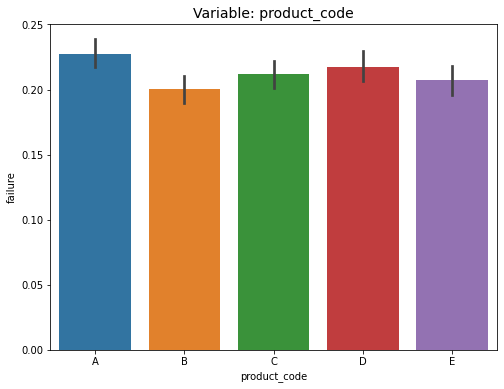

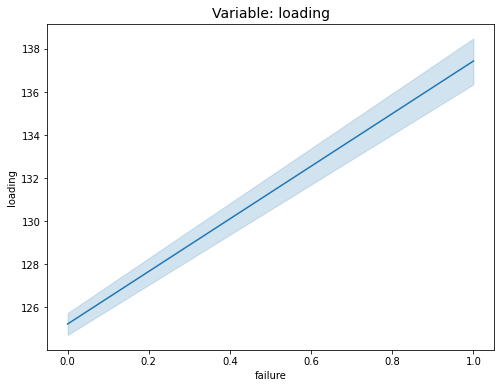

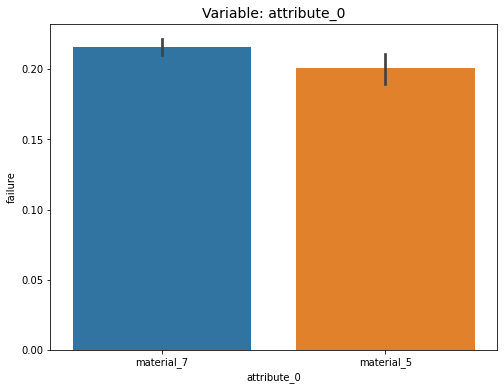

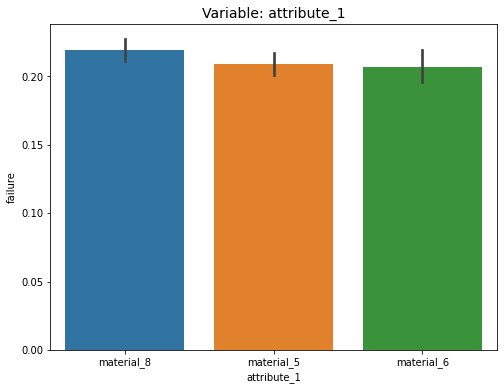

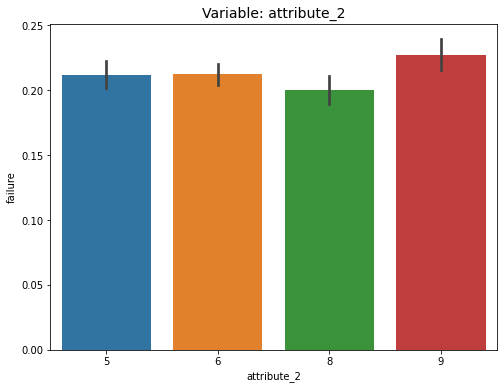

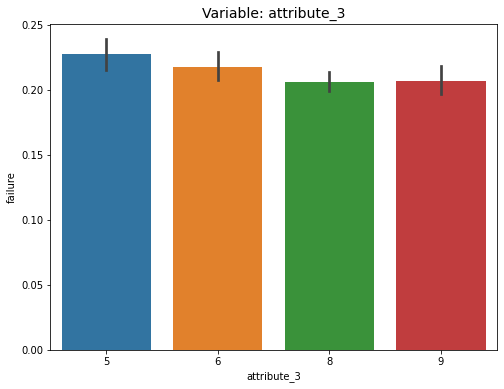

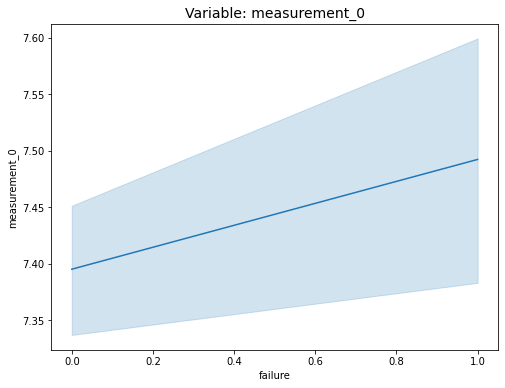

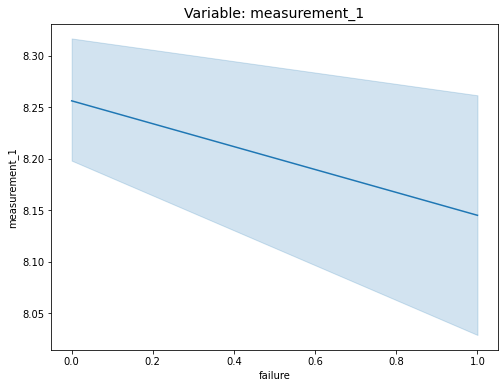

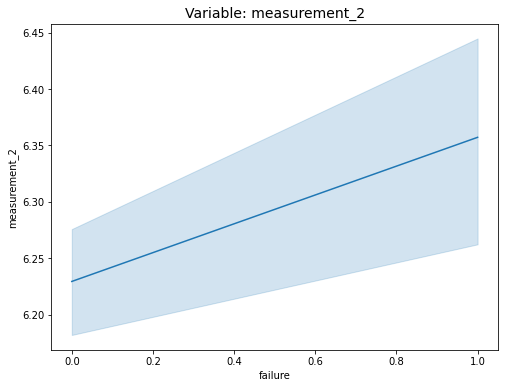

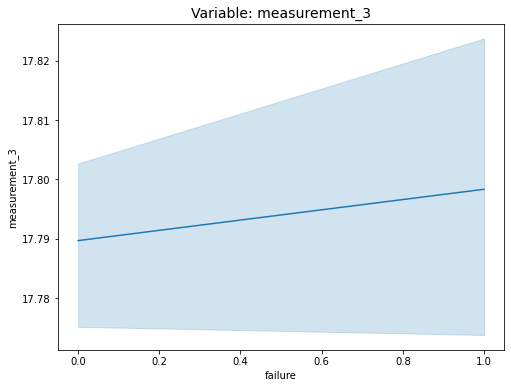

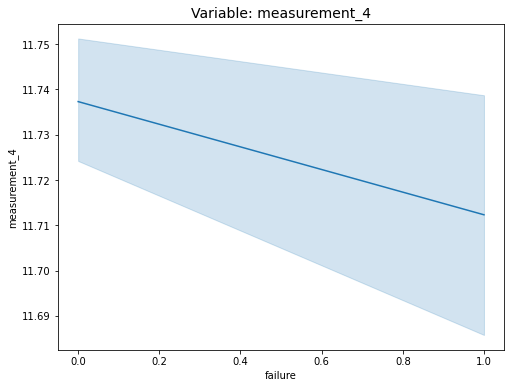

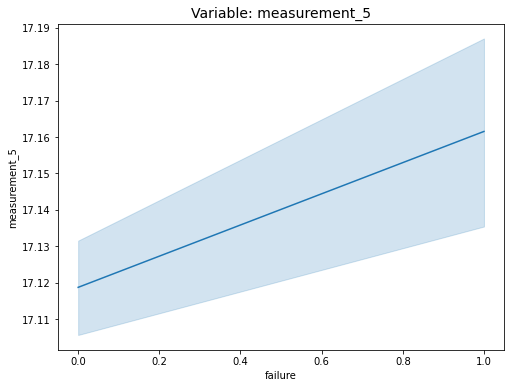

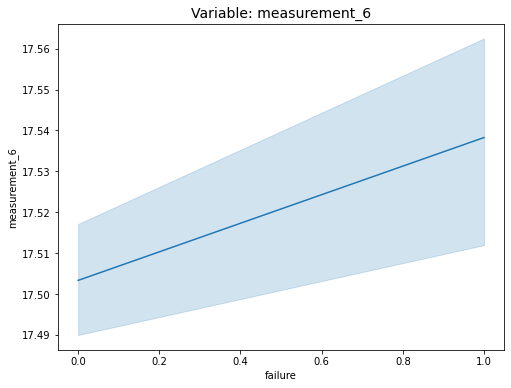

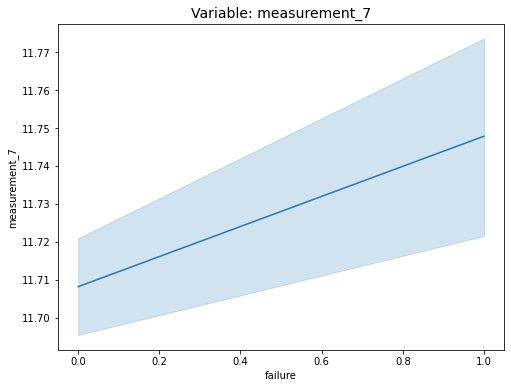

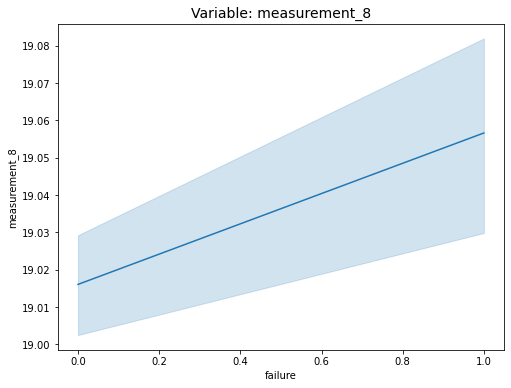

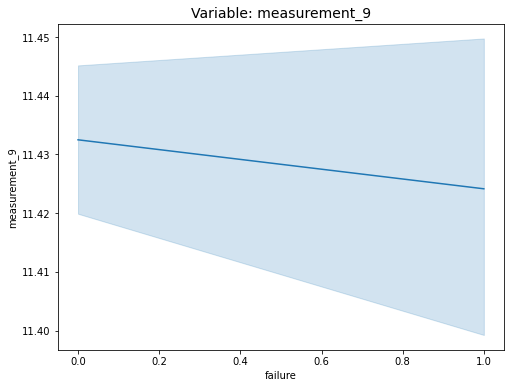

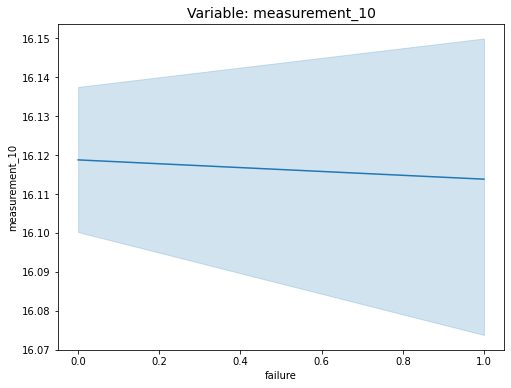

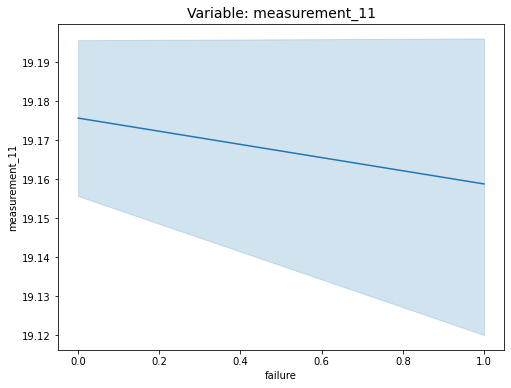

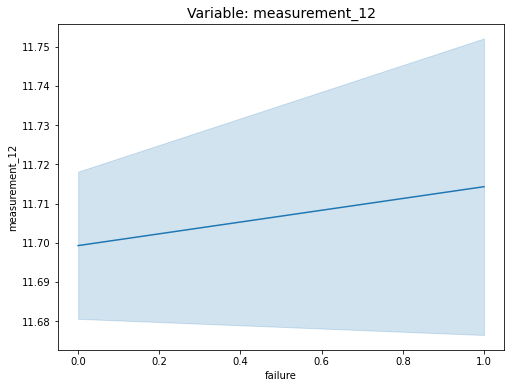

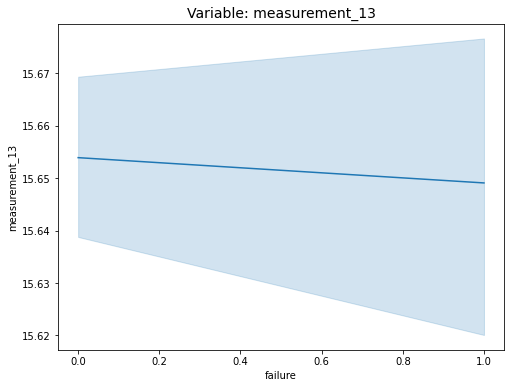

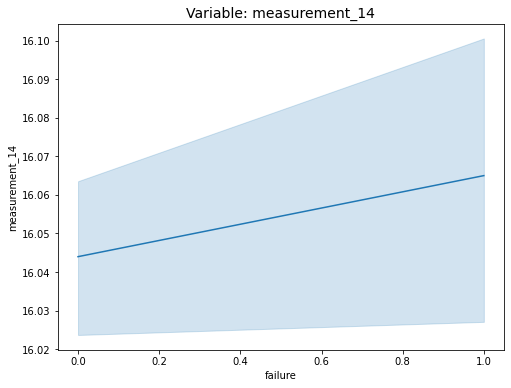

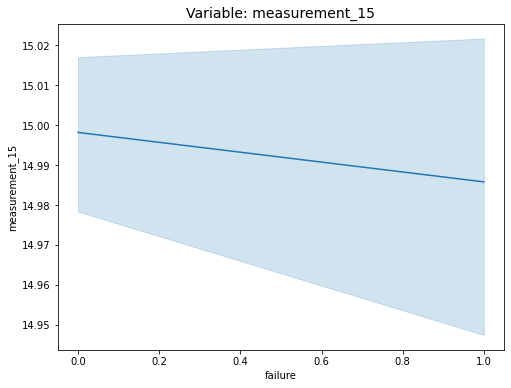

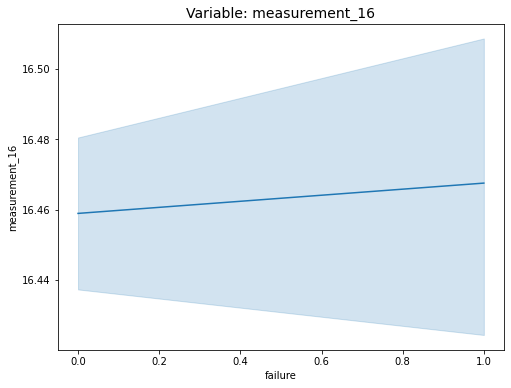

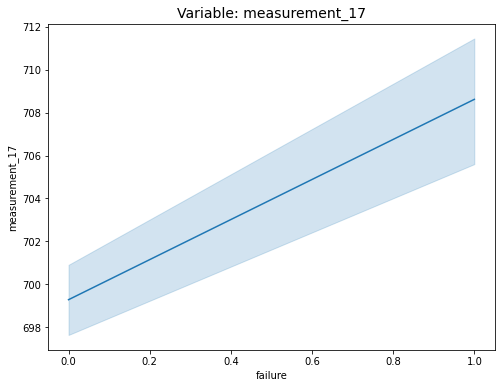

In [17]:
list_selected_vars = [c for c in train_df.columns if c not in ['id', 'failure']]
list_target_col = ['failure']

train_df_complete = train_df.copy()
train_df = train_df[list_selected_vars + list_target_col]

for var in list_selected_vars:
  # Categorical variable
  if len(train_df[var].unique()) <= 20:
    f, ax = plt.subplots(figsize=(8, 6))
    plt.title(f'Variable: {var}', fontsize=14)
    sns.barplot(x=var, y=list_target_col[0], data=train_df)
  # Numerical variable
  else:
    f, ax = plt.subplots(figsize=(8, 6))
    plt.title(f'Variable: {var}', fontsize=14)
    sns.lineplot(x=list_target_col[0], y=var, data=train_df)